In [2]:
pip install jieba

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 74.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for jieba: filename=jieba-0.42.1-py3-none-any.whl size=19314477 sha256=c964144f453fccef86f91346ef3bfc76c34c60a9a5a895d7e09b0d14f89d9d26
  Stored in directory: /root/.cache/pip/wheels/7d/74/cf/08c94db4b784e2c1ef675a600b7b5b281fd25240dcb954ee7e
Successfully built jieba

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 52.1 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 513.6/513.6 kB 52.7 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
import os
import random
import jieba
import re
import time
import numpy as np
import matplotlib.pyplot as plt
from gensim import corpora, models
from sklearn.svm import SVC                          # 分类器
from sklearn.model_selection import StratifiedKFold  # 做交叉验证
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split # 划分数据集

# 预处理

In [6]:
class ReadFile:
    def __init__(self, root_dir, stop_words_path):
        self.root_dir = root_dir
        self.stop_words_path = stop_words_path

    def get_corpus(self):
        with open(self.stop_words_path, 'r', encoding='utf-8') as stop_words_file:
            stop_words = [line.strip() for line in stop_words_file.readlines()]

        text_dict = {}

        r1 = '[a-zA-Z0-9’!"#$%&\'()*+,-./:：;<=>?@，。?★、…【】《》？“”‘’！[\\]^_`{|}~]+'
        listdir = os.listdir(self.root_dir)

        for file_name in listdir:
            path = os.path.join(self.root_dir, file_name)
            if os.path.isfile(path) and file_name.split('.')[-1] == 'txt' and file_name != 'inf.txt':
                with open(os.path.abspath(path), "r", encoding='gb18030') as file:
                    file_content = file.read()

                file_content = file_content. \
                    replace("本书来自www.cr173.com免费txt小说下载站", '')
                file_content = file_content. \
                    replace("更多更新免费电子书请关注www.cr173.com", '')
                file_content = re.sub(r1, '', file_content)
                file_content = file_content.replace("\n", '')
                file_content = file_content.replace(" ", '')
                file_content = file_content.replace('\u3000', '')

                new_words_lst = []
                split_words = list(jieba.cut(file_content))
                for word in split_words:
                    if word not in stop_words:
                        new_words_lst.append(word)

                print(file_name.split('.')[0], '总词数：', len(new_words_lst))
                
                text_dict[file_name.split('.')[0]] = new_words_lst

            elif os.path.isdir(path):
                print('文件路径不存在!!!!!!')
        return text_dict

In [7]:
read_file = ReadFile(root_dir="/work/data/", stop_words_path='/work/cn_stopwords.txt')
text_dict = read_file.get_corpus()

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.854 seconds.
Prefix dict has been built successfully.
三十三剑客图 总词数： 22179
书剑恩仇录 总词数： 174237
侠客行 总词数： 118939
倚天屠龙记 总词数： 322100
天龙八部 总词数： 397971
射雕英雄传 总词数： 304708
白马啸西风 总词数： 22322
碧血剑 总词数： 163314
神雕侠侣 总词数： 326467
笑傲江湖 总词数： 316834
越女剑 总词数： 5668
连城诀 总词数： 75150
雪山飞狐 总词数： 45289
飞狐外传 总词数： 148547
鸳鸯刀 总词数： 11756
鹿鼎记 总词数： 396105


# LDA训练

1. 均匀抽取1000个段落

2. 初始化：每个段落有paragraph_length=500个token，主题数量为num_topics=10

In [8]:

def LDA_train(text_dict, paragraph_num=1000, paragraph_length=500, num_topics=10, use_character=False, random_consistent=True, random_seed=0):
    
    # 将元素为词的列表转化为字
    if use_character:
        for label, text in text_dict.items():
            text_dict[label] = list(''.join(text))
    
    # 从每篇文章中抽取一定数目的段落
    # text_lst = []
    # label_lst = []
    # for label, text in text_dict.items():
    #     for i in range(0, paragraph_num):
    #         label_lst.append(label)
    #         if random_consistent:
    #             random.seed(random_seed)
    #         random_int = random.randint(0, len(text)-paragraph_length-1)
    #         text_lst.append(text[random_int:random_int+paragraph_length])
    
    # 从语料库中抽取一定长度一定数量的段落
    text_lst = []
    label_lst = []
    total_paragraphs = 0
    for label, text in text_dict.items():
        if total_paragraphs >= paragraph_num:
            break
        for _ in range(paragraph_num // len(text_dict)):
            if total_paragraphs >= paragraph_num:
                break
            total_paragraphs += 1
            label_lst.append(label)
            if random_consistent:
                random.seed(random_seed)
            random_int = random.randint(0, len(text)-paragraph_length-1)
            text_lst.append(text[random_int:random_int+paragraph_length])

    # 将标签列表从字符串形式映射为整数形式
    label_dict = {}
    for label in label_lst:
        if label not in label_dict:
            label_dict[label] = len(label_dict)
    # print(label_dict)
    int_label_lst = list(map(lambda x: label_dict[x], label_lst))

    # 保证标签列表与文本列表长度相同
    assert len(int_label_lst) == len(text_lst)

    # 生成一个打乱顺序的索引
    if random_consistent:
        np.random.seed(random_seed)
    indices = np.random.permutation(len(int_label_lst))

    # 使用索引将标签列表和数据列表的顺序按照相同方式打乱
    int_label_list = [int_label_lst[i] for i in indices]
    text_list = [text_lst[i] for i in indices]

    # 划分训练集与测试集
    # 采用0.9的训练：测试比
    train_p = 0.9
    label_train = int_label_list[0:int(len(int_label_list)*train_p)]
    label_test = int_label_list[int(len(int_label_list)*train_p):]
    text_train = text_list[0:int(len(text_list)*train_p)]
    text_test = text_list[int(len(int_label_list)*train_p):]

    # 将文本列表转化为LDA模型需要的输入——文本向量
    dictionary = corpora.Dictionary(text_list)
    corpus_train = [dictionary.doc2bow(doc) for doc in text_train]
    corpus_test = [dictionary.doc2bow(doc) for doc in text_test]

    #print('训练集段落数:',len(corpus_train))
    #print('测试集段落数:',len(corpus_test))
    
    # 训练LDA模型
    lda = models.LdaModel(corpus=corpus_train, id2word=dictionary, num_topics=num_topics)
   
    # 打印每个主题的主要词分布
    for topic_id in range(num_topics):
        print(f"Topic {topic_id}:")
        print(lda.show_topic(topic_id))
    
    # 获取训练集和测试集的每个段落的主题分布
    topics_train = lda.get_document_topics(corpus_train, minimum_probability=0)
    topics_test = lda.get_document_topics(corpus_test, minimum_probability=0)
    feature_train = []
    feature_test = []

    for i in range(0, len(topics_train)):
        feature_train.append([k[1] for k in topics_train[i]])

    for i in range(0, len(topics_test)):
        feature_test.append([k[1] for k in topics_test[i]])

    print('训练集特征矩阵大小为:', np.array(feature_train).shape)
    print('测试集特征矩阵大小为:', np.array(feature_test).shape)
    
    # 定义分类器
    clf = SVC(kernel='rbf', decision_function_shape='ovr') # SVM
    # clf = RandomForestClassifier(n_estimators=100)       # 随机森林
    # 训练模型
    clf.fit(feature_train, label_train)

    # 测试模型
    predict_train = clf.predict(feature_train)
    predict_test = clf.predict(feature_test)
    
    print(list(predict_test))
    print(label_test)
    
    accuracy_train = clf.score(feature_train, label_train)
    print(f'Train Accuracy: {100*accuracy_train:.2f}%')
    accuracy_test = clf.score(feature_test, label_test)
    print(f'Test Accuracy: {100*accuracy_test:.2f}%')
    
    return accuracy_train, accuracy_test


In [ ]:
'''
def LDA_train(text_dict, paragraph_num=63, paragraph_length=500, num_topics=10, use_character=False, random_consistent=True, random_seed=0):
    
    # Convert word lists to character lists if required
    if use_character:
        for label, text in text_dict.items():
            text_dict[label] = list(''.join(text))
    
    # Extract paragraphs from the corpus
    text_lst = []
    label_lst = []
    for label, text in text_dict.items():
        for i in range(0, paragraph_num):
            label_lst.append(label)
            if random_consistent:
                random.seed(random_seed)
            random_int = random.randint(0, len(text)-paragraph_length-1)
            text_lst.append(text[random_int:random_int+paragraph_length])

    # Map label strings to integer labels
    label_dict = {}
    for label in label_lst:
        if label not in label_dict:
            label_dict[label] = len(label_dict)
    int_label_lst = list(map(lambda x: label_dict[x], label_lst))

    # Ensure label and text lists have the same length
    assert len(int_label_lst) == len(text_lst)

    # Generate shuffled indices
    if random_consistent:
        np.random.seed(random_seed)
    indices = np.random.permutation(len(int_label_lst))

    # Shuffle label and text lists using the generated indices
    int_label_list = [int_label_lst[i] for i in indices]
    text_list = [text_lst[i] for i in indices]

    # Prepare for cross-validation
    kf = KFold(n_splits=10, shuffle=True, random_state=random_seed)
    accuracies_train = []
    accuracies_test = []

    # Perform 10-fold cross-validation
    for train_index, test_index in kf.split(text_list):
        text_train = [text_list[i] for i in train_index]
        text_test = [text_list[i] for i in test_index]
        label_train = [int_label_list[i] for i in train_index]
        label_test = [int_label_list[i] for i in test_index]

        # Convert text lists to LDA model input format (bag-of-words)
        dictionary = corpora.Dictionary(text_list)
        corpus_train = [dictionary.doc2bow(doc) for doc in text_train]
        corpus_test = [dictionary.doc2bow(doc) for doc in text_test]

        # Train LDA model
        lda = models.LdaModel(corpus=corpus_train, id2word=dictionary, num_topics=num_topics)
        # 打印每个主题的主要词分布
        # for topic_id in range(num_topics):
        #     print(f"Topic {topic_id}:")
        #     print(lda.show_topic(topic_id))
        # Get topic distribution for each paragraph in train and test sets
        topics_train = lda.get_document_topics(corpus_train, minimum_probability=0)
        topics_test = lda.get_document_topics(corpus_test, minimum_probability=0)
        feature_train = [[k[1] for k in topics_train[i]] for i in range(len(topics_train))]
        feature_test = [[k[1] for k in topics_test[i]] for i in range(len(topics_test))]

        # print('训练集特征矩阵大小为:', np.array(feature_train).shape)
        # print('测试集特征矩阵大小为:', np.array(feature_test).shape)

        # Define classifier
        clf = SVC(kernel='rbf', decision_function_shape='ovr') # SVM
        # clf = RandomForestClassifier(n_estimators=100)       # Random Forest
        
        # Train the classifier
        clf.fit(feature_train, label_train)

        # Test the classifier
        accuracy_train = clf.score(feature_train, label_train)
        accuracy_test = clf.score(feature_test, label_test)
        
        accuracies_train.append(accuracy_train)
        accuracies_test.append(accuracy_test)
    
    # Calculate average accuracies over all folds
    avg_accuracy_train = np.mean(accuracies_train)
    avg_accuracy_test = np.mean(accuracies_test)
    
    print(f'Average Train Accuracy: {100*avg_accuracy_train:.2f}%')
    print(f'Average Test Accuracy: {100*avg_accuracy_test:.2f}%')
    
    return avg_accuracy_train, avg_accuracy_test
'''

'\ndef LDA_train(text_dict, paragraph_num=63, paragraph_length=500, num_topics=10, use_character=False, random_consistent=True, random_seed=0):\n    \n    # Convert word lists to character lists if required\n    if use_character:\n        for label, text in text_dict.items():\n            text_dict[label] = list(\'\'.join(text))\n    \n    # Extract paragraphs from the corpus\n    text_lst = []\n    label_lst = []\n    for label, text in text_dict.items():\n        for i in range(0, paragraph_num):\n            label_lst.append(label)\n            if random_consistent:\n                random.seed(random_seed)\n            random_int = random.randint(0, len(text)-paragraph_length-1)\n            text_lst.append(text[random_int:random_int+paragraph_length])\n\n    # Map label strings to integer labels\n    label_dict = {}\n    for label in label_lst:\n        if label not in label_dict:\n            label_dict[label] = len(label_dict)\n    int_label_lst = list(map(lambda x: label_dict[x

## 改变T

In [ ]:
num_topics_lst = [1,5,10,20,30,40,50,100,200,300,400,500]
T_accuracy_train_lst = []
T_accuracy_test_lst = []
for num_topics in num_topics_lst:
    T_accuracy_train, T_accuracy_test = LDA_train(text_dict, paragraph_num=1000, paragraph_length=500, num_topics=num_topics, use_character=False, random_consistent=False)
    T_accuracy_train_lst.append(T_accuracy_train)
    T_accuracy_test_lst.append(T_accuracy_test)

[('道', 0.013385117), ('钟万仇', 0.011186138), ('中', 0.0044609085), ('石屋', 0.004192326), ('一个', 0.0037715493), ('忙', 0.0032951445), ('段正淳', 0.003178322), ('女儿', 0.0031644686), ('女子', 0.0030973514), ('钟灵', 0.0029522018)]
Topic 4:
[('老人', 0.011314928), ('道', 0.010881642), ('计', 0.009371458), ('李文秀', 0.007496241), ('丁同', 0.006165795), ('说', 0.0059924116), ('便', 0.0057194633), ('一声', 0.0052769165), ('见', 0.005105567), ('中', 0.004993533)]
Topic 5:
[('道', 0.013920398), ('韦小宝', 0.011975471), ('说', 0.008096809), ('杀', 0.007263114), ('便', 0.0046032406), ('施琅', 0.0041295616), ('卑职', 0.003796368), ('中', 0.0037684478), ('郑成功', 0.0037455407), ('一个', 0.0030713247)]
Topic 6:
[('道', 0.022096936), ('说', 0.006083653), ('苗若兰', 0.005266308), ('麽', 0.0046588248), ('曹云奇', 0.0044617816), ('听', 0.0037982988), ('韦小宝', 0.0032880236), ('说道', 0.0030733396), ('杨行密', 0.0030125463), ('平阿四', 0.0029787868)]
Topic 7:
[('道', 0.015663628), ('说', 0.0074368874), ('说道', 0.00593444), ('陈家洛', 0.0054195183), ('便', 0.005321436), ('

In [12]:
def plot_accuracy(x_lst, accuracy_train_lst, accuracy_test_lst, x_label, filename):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), dpi=300)

    x = x_lst
    new_x = np.arange(len(x))
    y1 = accuracy_train_lst
    y2 = accuracy_test_lst

    axes[0].plot(new_x, y1)
    axes[0].set_title("train_acc")
    axes[0].set_xticks(new_x)
    axes[0].set_xticklabels(x)
    axes[0].set_xlabel(x_label)
    axes[0].set_ylabel('acc')

    axes[1].plot(new_x, y2)
    axes[1].set_title("test_acc")
    axes[1].set_xticks(new_x)
    axes[1].set_xticklabels(x)
    axes[1].set_xlabel(x_label)
    axes[1].set_ylabel('acc')

    # 保存图像
    plt.savefig(f'/work/Pic/{filename}.png', bbox_inches='tight')

    # 显示图像
    plt.show()



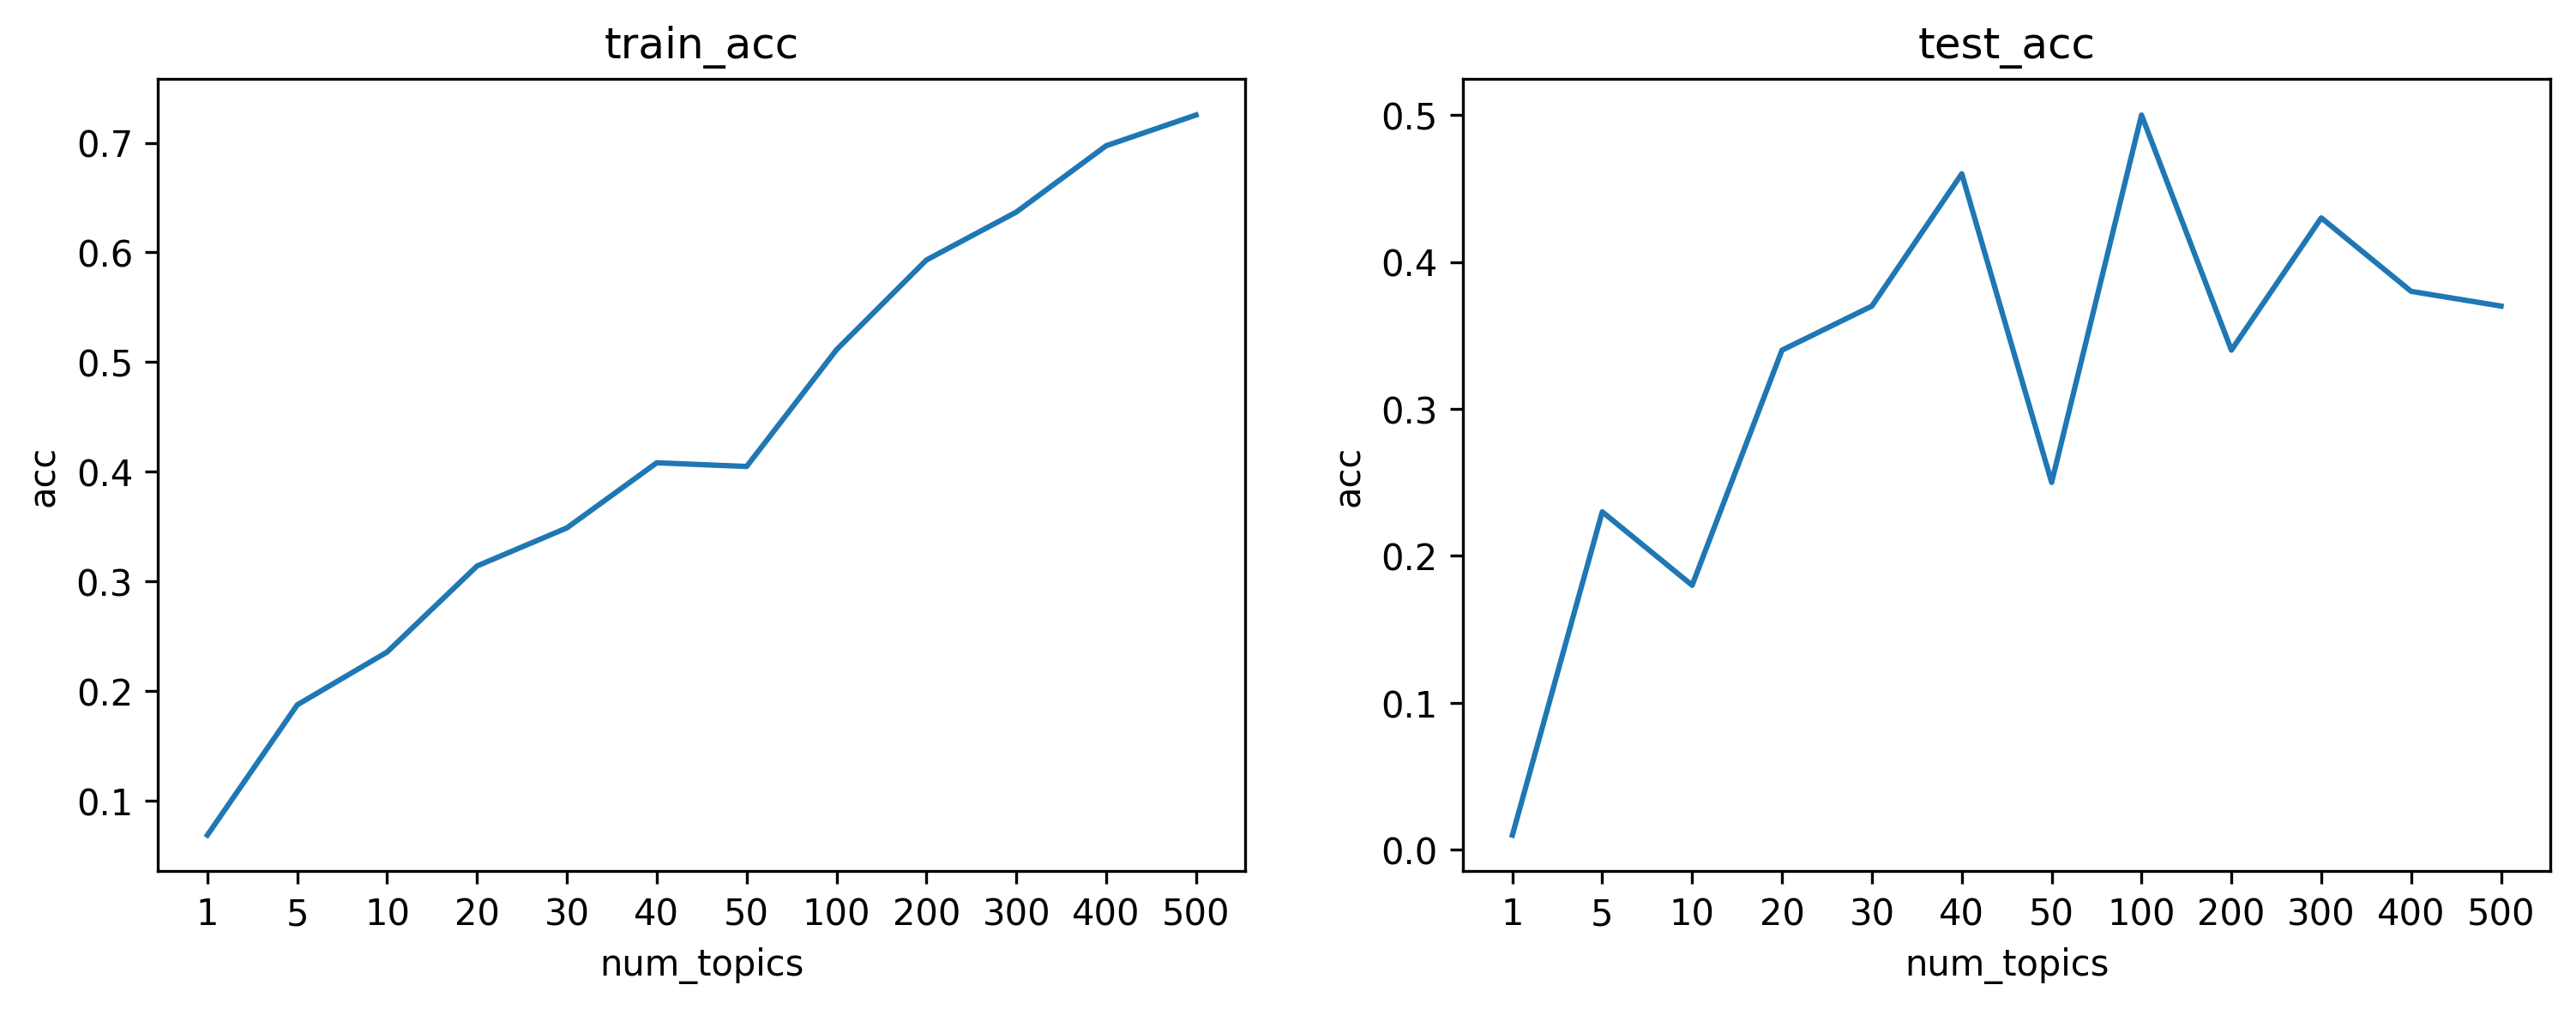

In [ ]:
plot_accuracy(num_topics_lst, T_accuracy_train_lst, T_accuracy_test_lst, 'num_topics', 'T_change')

## 改变K

In [9]:
K_lsts = [20, 100, 500, 1000, 3000]
K_accuracy_train_lst = []
K_accuracy_test_lst = []
for K_lst in K_lsts:
    K_accuracy_train, K_accuracy_test = LDA_train(text_dict, paragraph_num=1000, paragraph_length=K_lst, num_topics= 50, use_character=False, random_consistent=False)
    K_accuracy_train_lst.append(K_accuracy_train)
    K_accuracy_test_lst.append(K_accuracy_test)

Topic 0:
[('道', 0.013024392), ('便', 0.006571666), ('说道', 0.0056070094), ('没', 0.0046988525), ('老人', 0.0046130316), ('一个', 0.0045721796), ('李文秀', 0.0044330573), ('始终', 0.0042884094), ('姑娘', 0.0040681036), ('两个', 0.0034440816)]
Topic 1:
[('身上', 0.008349553), ('便', 0.008329628), ('道', 0.008139391), ('范蠡', 0.006685188), ('知道', 0.006684714), ('众人', 0.0050239046), ('四人', 0.0050216056), ('大声', 0.0050005387), ('时', 0.004921672), ('轻轻', 0.0033598302)]
Topic 2:
[('道', 0.01579435), ('没', 0.011289886), ('痛', 0.00754201), ('说道', 0.0054285424), ('腰带', 0.005010115), ('迷宫', 0.0037907881), ('找到', 0.0037891073), ('性命', 0.0037882521), ('紫檀', 0.003788063), ('郭靖', 0.0037880605)]
Topic 3:
[('一个', 0.009698332), ('道', 0.0091935005), ('少妇', 0.007256264), ('蝴蝶', 0.0048560943), ('一声', 0.0048555387), ('剑士', 0.0048552947), ('著', 0.004855024), ('一刀', 0.004854856), ('石门', 0.004853625), ('终于', 0.0048524337)]
Topic 4:
[('道', 0.02823977), ('说', 0.0062463093), ('杀', 0.005917586), ('剑', 0.0055324496), ('宝剑', 0.0050228103

In [10]:
K_accuracy_train_lst

[0.18497757847533633,
 0.24551569506726456,
 0.3665919282511211,
 0.4742152466367713,
 0.7096412556053812]

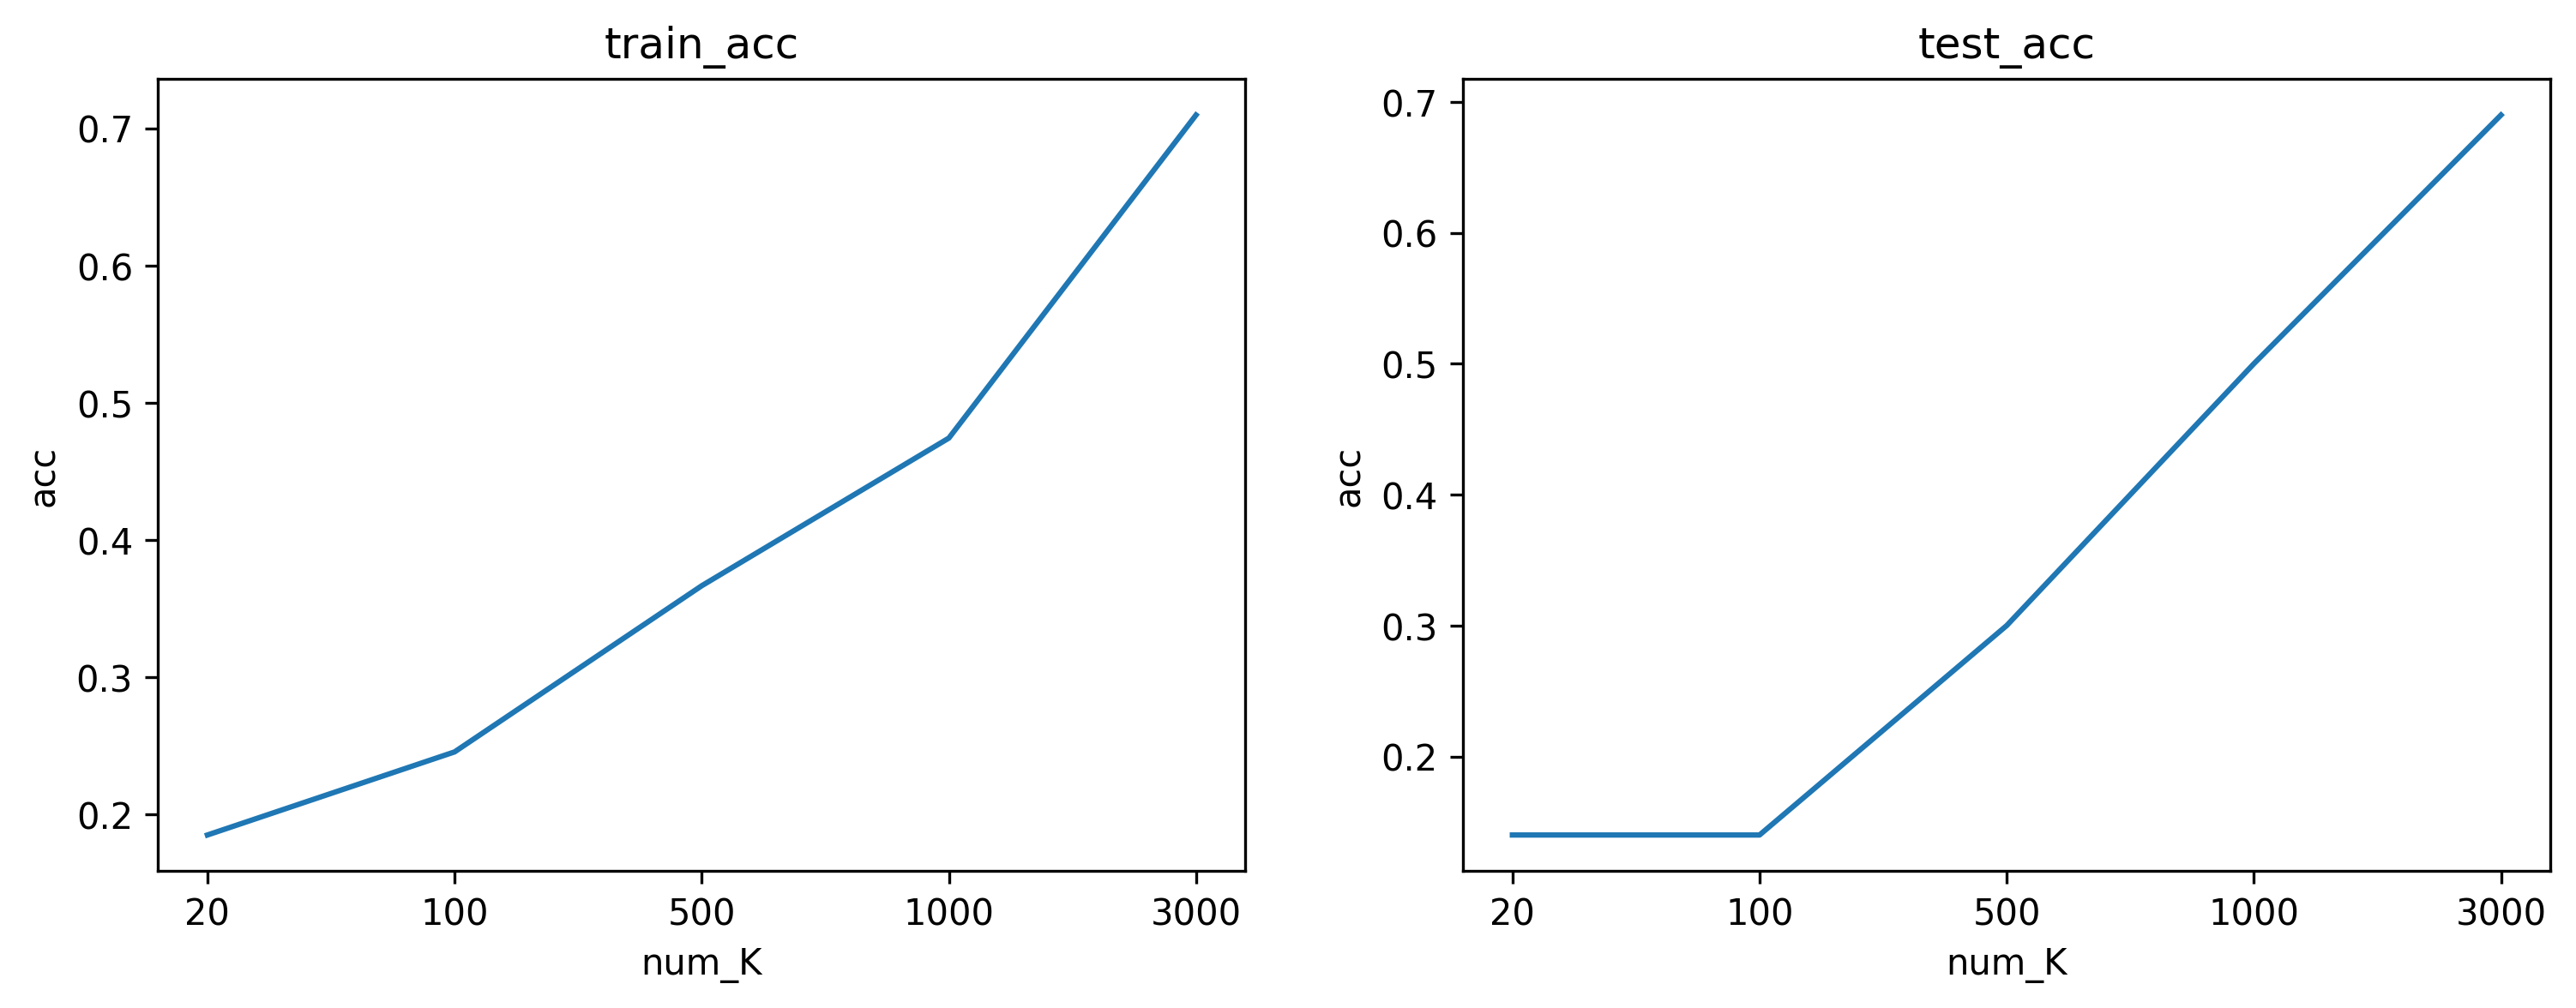

In [13]:
plot_accuracy(K_lsts, K_accuracy_train_lst, K_accuracy_test_lst, 'num_K', 'K_change')

## 字or词

In [14]:
# LDA_train(text_dict, paragraph_num=1000, paragraph_length=K_lst, num_topics=100, use_character=False, random_consistent=False)
accuracy_train_character, accuracy_test_character = LDA_train(text_dict, paragraph_num=1000, paragraph_length=500, num_topics=100, use_character=True, random_consistent=False)
accuracy_train_word, accuracy_test_word = LDA_train(text_dict, paragraph_num=1000, paragraph_length=500, num_topics=100, use_character=False, random_consistent=False)

Topic 0:
[('一', 0.01667684), ('人', 0.014349709), ('道', 0.012261933), ('不', 0.010612548), ('女', 0.009480691), ('中', 0.008382541), ('大', 0.0074207955), ('上', 0.006774468), ('之', 0.006763007), ('说', 0.0063574775)]
Topic 1:
[('道', 0.023222167), ('不', 0.021225024), ('一', 0.020226855), ('人', 0.019433413), ('手', 0.009011728), ('中', 0.0085518155), ('子', 0.008333017), ('说', 0.007727574), ('大', 0.006180779), ('之', 0.0060974127)]
Topic 2:
[('道', 0.025312498), ('一', 0.019442026), ('人', 0.016813032), ('大', 0.013238247), ('不', 0.0119459815), ('手', 0.009978364), ('中', 0.008588711), ('剑', 0.008426958), ('小', 0.008285287), ('来', 0.008186043)]
Topic 3:
[('一', 0.02657032), ('人', 0.014966137), ('不', 0.013264448), ('道', 0.013149639), ('下', 0.010392858), ('中', 0.009478917), ('来', 0.008649435), ('子', 0.007721737), ('手', 0.007190242), ('大', 0.006815053)]
Topic 4:
[('不', 0.020129215), ('一', 0.018636806), ('道', 0.014272294), ('人', 0.01405784), ('手', 0.012397122), ('中', 0.011661774), ('大', 0.009071406), ('说', 0.

In [16]:
accuracy_train_character

0.5358744394618834

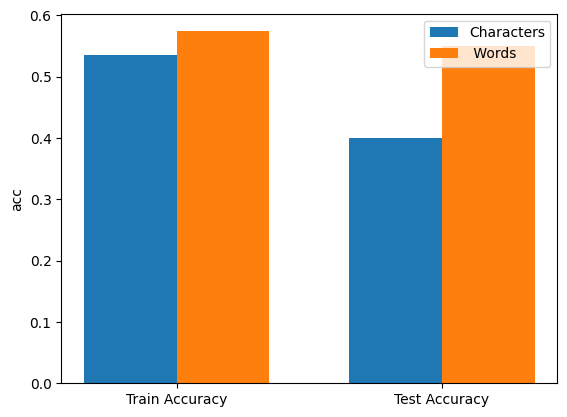

In [23]:
labels = ['Train Accuracy', 'Test Accuracy']
accuracy1 = [accuracy_train_character, accuracy_test_character]
accuracy2 = [accuracy_train_word, accuracy_test_word]

x = range(len(labels))
width = 0.35

# Plotting
fig, ax = plt.subplots()
rects1 = ax.bar(x, accuracy1, width, label='Characters')
rects2 = ax.bar([i + width for i in x], accuracy2, width, label=' Words')


ax.set_ylabel('acc')
ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels(labels)
ax.legend()
plt.savefig(f'/work/Pic/word_or_characters.png', bbox_inches='tight', dpi=300)
plt.show()



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2cb3a74c-06a9-4cf0-b3a4-3a0dc0022150' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>